# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

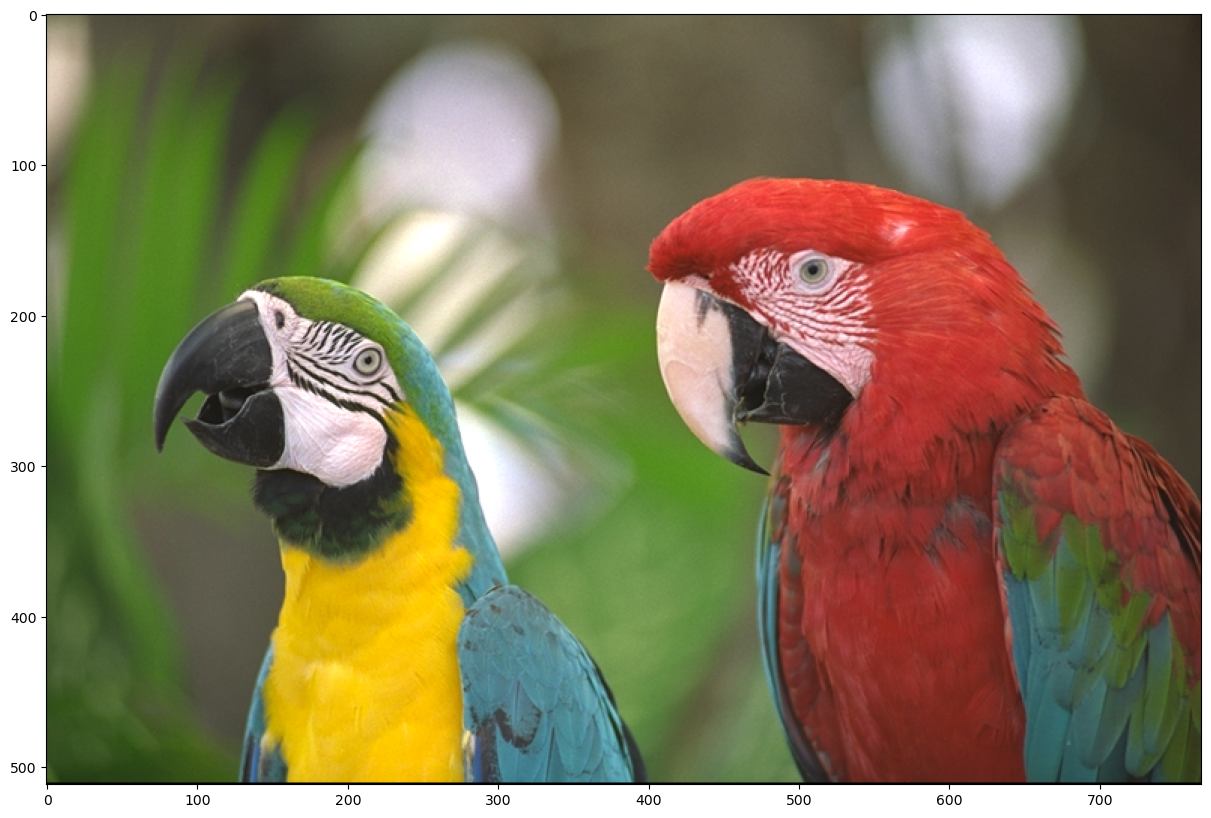

In [3]:
# Load image
img = cv2.imread('data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [5]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [81]:
def psnr(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    mse = np.mean(error**2)
    return 10 * np.log10((255**2)/mse)

def quantization(img, colors):
    # Cast the image to float
    img_tmp = img.astype(np.float32)
    
    # Prepare for quantization
    rows, cols, channels = img_tmp.shape
    quantized = np.zeros_like(img_tmp)

    # Apply quantization
    for r in range(rows):
        for c in range(cols):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]
        
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            distances = np.linalg.norm(colors - pixel, axis=1)
            new_pixel = colors[np.argmin(distances)]  # Pick the closest color
            
            # Apply quantization
            quantized[r, c, :] = new_pixel

    return quantized.astype(np.uint8)


14.826061453276782


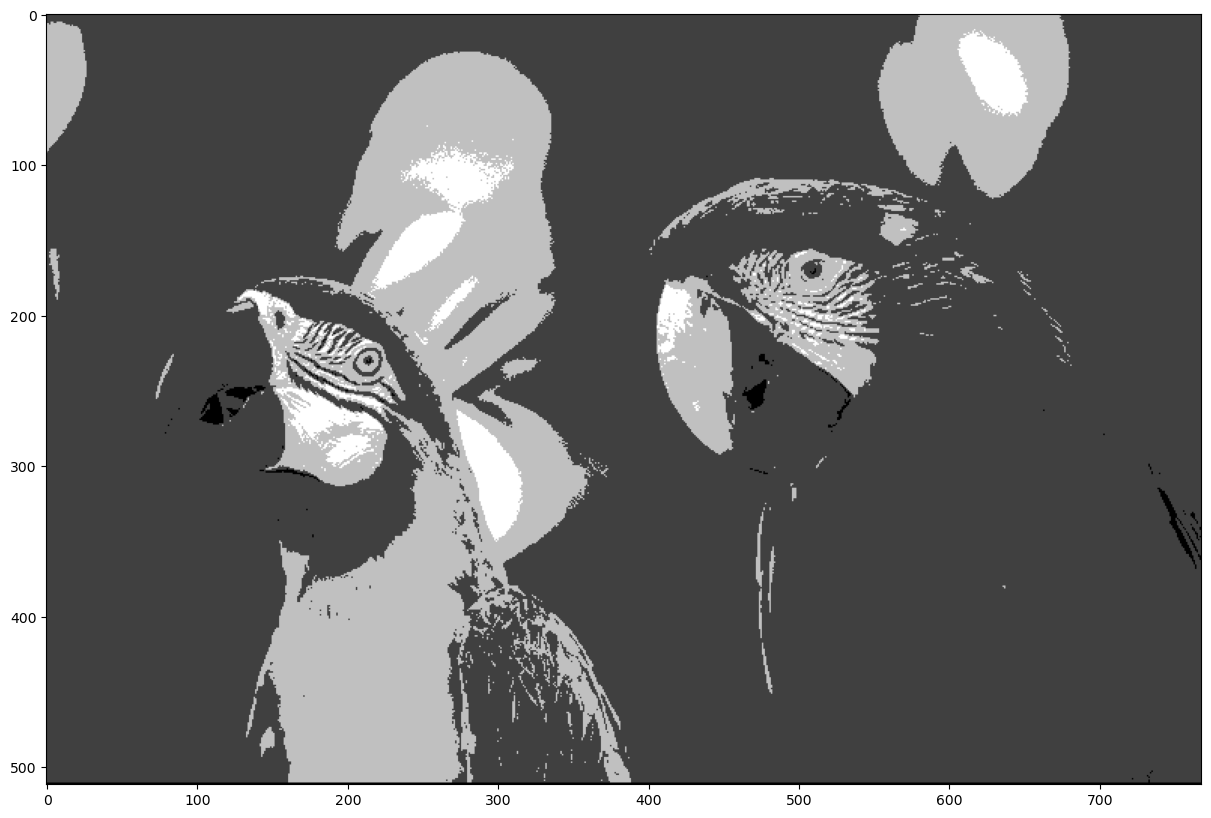

In [55]:
# Show quantized image (don't forget to cast back to uint8)
quantized = quantization(img, colors)
plt.imshow(quantized)


# Compute average quantization error
avg_quant_error = psnr(img, quantized) 
print(avg_quant_error)

#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [69]:
def floyd_steinberg_dithering(img, colors):
    # Make a temporal copy of the original image, we will need it for error diffusion
    img_tmp = img.astype(np.float32)
    dithering = np.zeros_like(img_tmp)

    rows, cols, channels = img_tmp.shape

    for r in range(1, rows-1):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = img_tmp[r, c, :]
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            distances = np.linalg.norm(colors - pixel, axis=1)
            new_pixel = colors[np.argmin(distances)] 
            
            # Compute quantization error
            quant_error = pixel - new_pixel
            
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here
            img_tmp[r, c, :] = new_pixel  # Assign quantized value to current pixel
            img_tmp[r, c + 1, :] += quant_error * (7 / 16)  # Right
            img_tmp[r + 1, c - 1, :] += quant_error * (3 / 16)  # Bottom-left
            img_tmp[r + 1, c, :] += quant_error * (5 / 16)  # Bottom
            img_tmp[r + 1, c + 1, :] += quant_error * (1 / 16)  # Bottom-right
            
            # Apply dithering
            dithering[r, c, :] = new_pixel
    
    return dithering.astype(np.uint8)

(<Axes: >, <matplotlib.image.AxesImage at 0x17fad1610>)

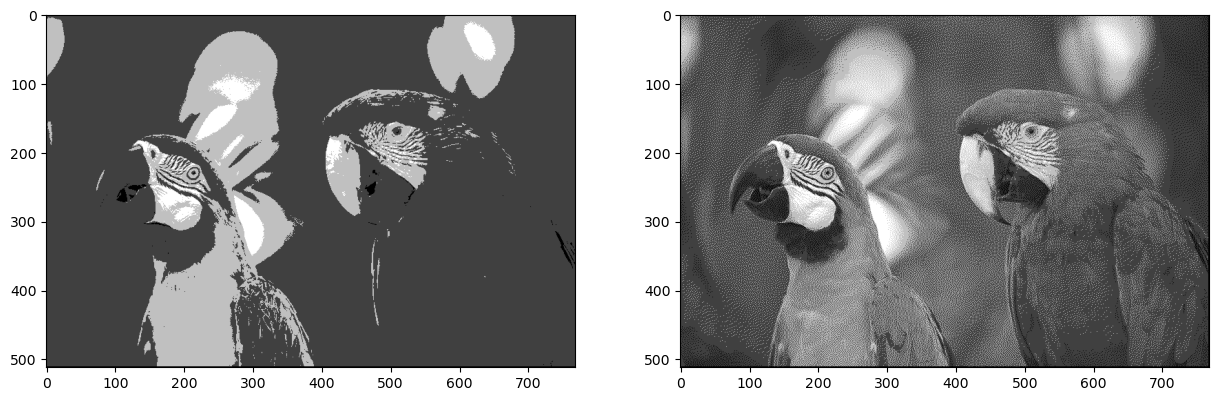

In [71]:
dithering = floyd_steinberg_dithering(img, colors)

# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

In [73]:
# Compute average quantization error for dithered image
avg_dith_error = psnr(img, dithering)
print(avg_dith_error)

12.941287100459139


6.443434934740848


(<Axes: >, <matplotlib.image.AxesImage at 0x174d982f0>)

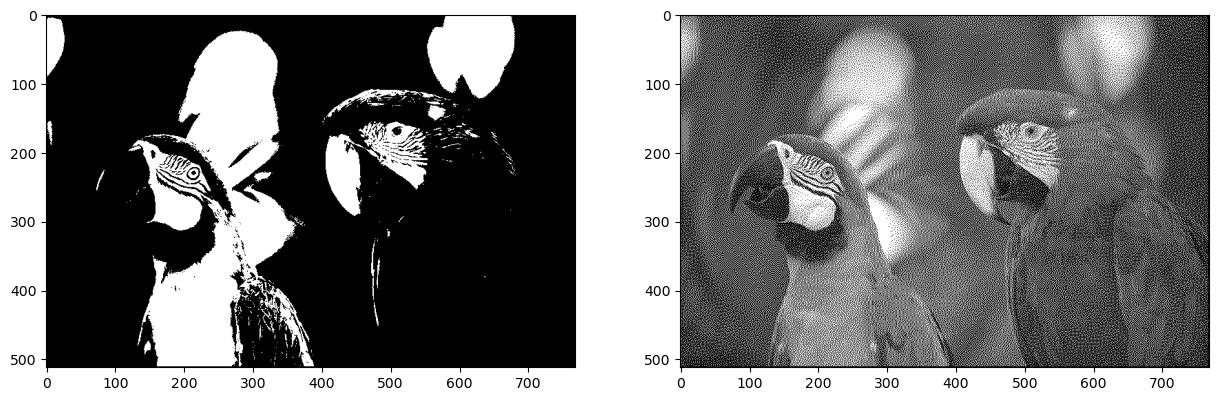

In [75]:
black_and_white_colors = np.array([[0, 0, 0], [255, 255, 255]])

quantized = quantization(img, black_and_white_colors)
dithering = floyd_steinberg_dithering(img, black_and_white_colors)

avg_dith_error = psnr(img, dithering)
print(avg_dith_error)

plt.subplot(121), plt.imshow(quantized)   # optimally quantized
plt.subplot(122), plt.imshow(dithering)   # dithering

### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
  The optimally quantized image has a higher quantization error.
* Which image looks better to you?
  Dithered image looks much better.
* Can you repeat the same process using only two colours: black and white? Show me :-)

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

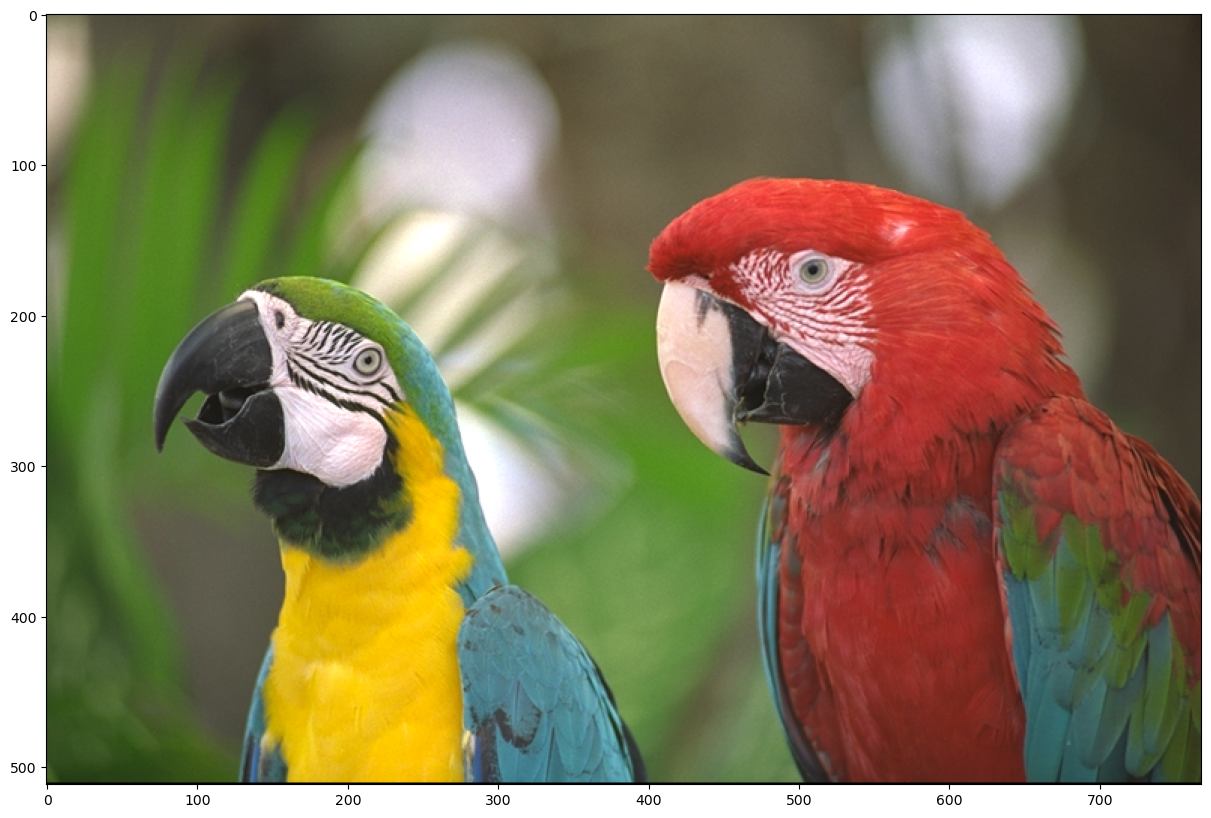

In [77]:
plt.imshow(img)

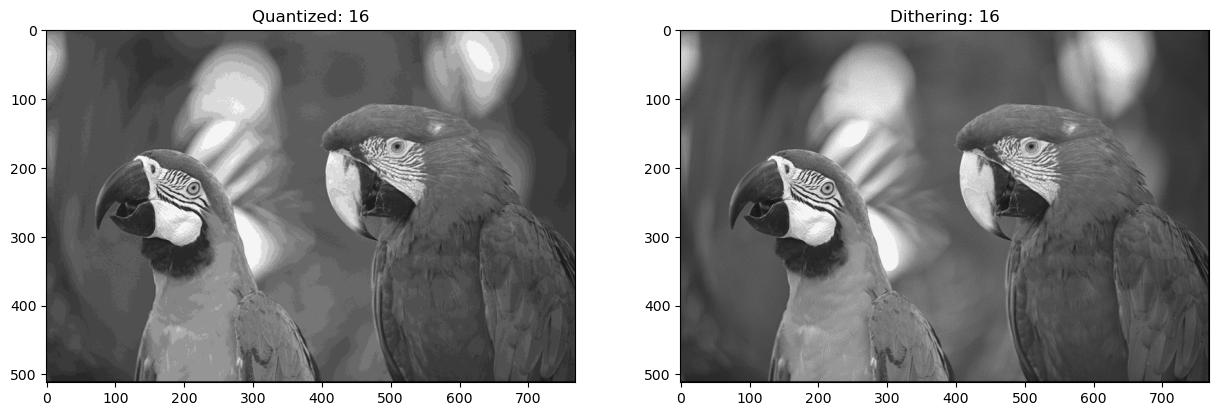

In [101]:
from sklearn.cluster import KMeans

def experiment(image, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(np.reshape(image, (-1, 1)))
    colors = kmeans.cluster_centers_

    quantized = quantization(image, colors)
    dithering = floyd_steinberg_dithering(image, colors)

    plt.subplot(121), plt.imshow(quantized.astype(np.uint8)), plt.title('Quantized: ' + repr(len(colors))) 
    plt.subplot(122), plt.imshow(dithering.astype(np.uint8)), plt.title('Dithering: ' + repr(len(colors)))


experiment(img, 16)

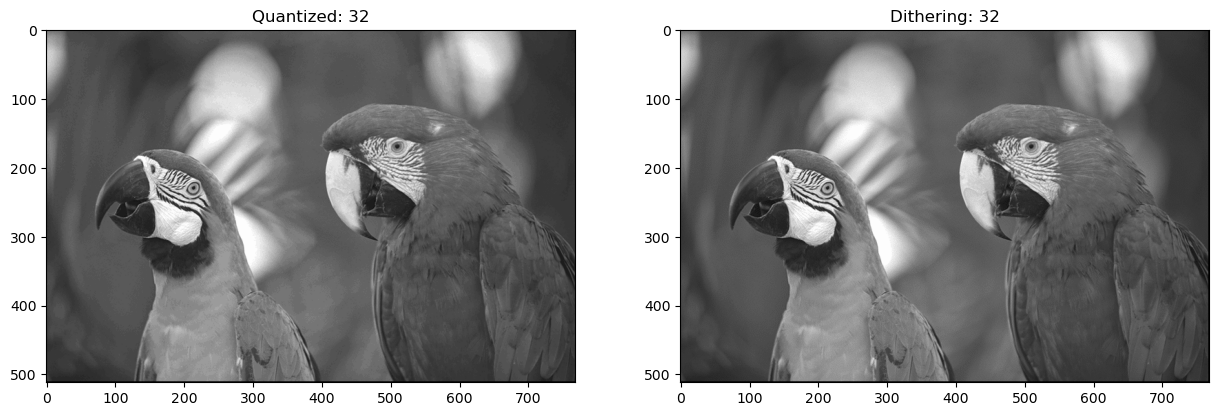

In [102]:
experiment(img, 32)

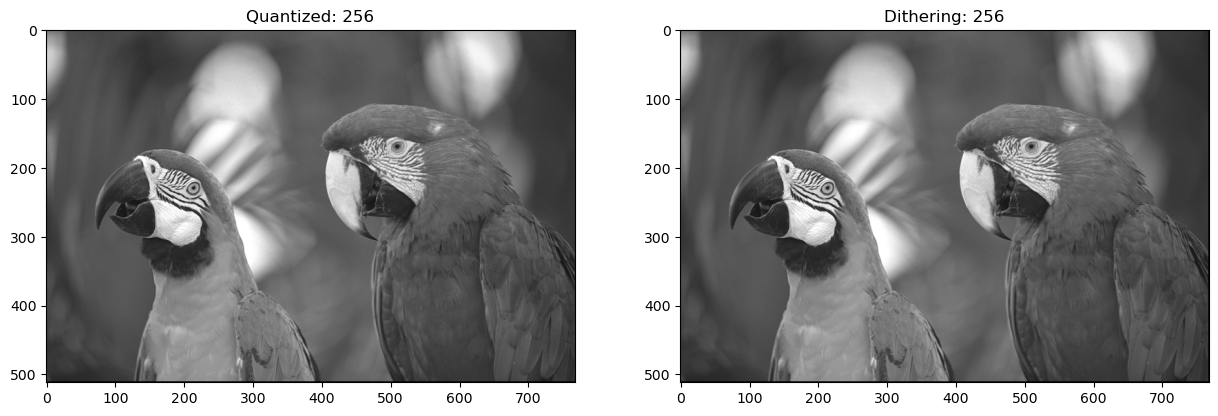

In [103]:
experiment(img, 256)

Apply FS dithering the same way you did before.
* How does the result look like to you?
  It looks great! I don't see any noise or artifacts.
* What happens if we use 32 colours?
  Actually, the result is the same 
* And what happens if we use 256 colours?
  Actually, the result is the same 